In [7]:
# Import packages
from pymongo import MongoClient
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [8]:
# Connect to db collections
client = MongoClient('mongodb://localhost:27017/')
db = client['address-clustering']
transfers = db['transfers']
transactions = db['transactions']

# Get addresses active on Ethereum and Polygon as a list
users = pd.read_csv('../data/subsets.csv')
user_addresses = list(set(users.loc[users['Polygon'] == 1, 'Address']).union(users.loc[users['Ethereum'] == 1, 'Address']))
user_addresses

['0x8b512915b87824dee52bff27d1935bb8639d4d2c',
 '0x85f6b7b1d64c63978057344a1219466df125f562',
 '0xd7c02b5db97b6b0e36db3ff7c83ec48fd75ada23',
 '0x3bae1b10af5ca69b1530dbe557f9e0190fdf191c',
 '0x9e13e8c907ec7e05c5c6114de79202fc32e30fce',
 '0x509a26cee691d46dc3deb1d93fd57c61a63f70ce',
 '0x096414854dbf64386f2058c415510e4b8afa95f6',
 '0xcef6e5a5e8b750116c10906a9855184502c14de4',
 '0xb7b47d7bbc3c9296a89ef29b8d25c20835e69bde',
 '0x39201f3d8c1b40bb3a591464a5a2ddd267b02e60',
 '0x60c5aeea17f181f4df5fe4f56dba6bbf52a2f3c6',
 '0x84a4e1b3c0054afe46d89d7794a507c23bfe932a',
 '0x4f185ab3750615cc6d7c655954fba25a14bb688f',
 '0x5629575d2dcd94dbdaebbbc74663e5fe979ecaf1',
 '0xd1ebba92cc7bf0a0f1b63a59e6fc075c049ecf49',
 '0x5f134df6b78ce3561eb9a9a298832f97fe97e8ec',
 '0xcd633e2693fbcde2f5ad9698bd16e23f034b6158',
 '0x4ee5e85f7e5366aee67b39e930dd4bc154531d46',
 '0xda72bce03c24bdd9d68ce5c15d255c40701ed3ee',
 '0xeec610a790d78bd7bf78dc40777bffe238a9599c',
 '0xee1a89896c3c1abb53fa78714865a0badf124da4',
 '0x4e61ad720

In [ ]:
def get_rank_new(X, address1, address2, method='faiss'):
    if address1 in node_map and address2 in node_map:
        query_idx = node_map[address1]
        target_idx = node_map[address2]

        if method == 'faiss':
            distances, indices = get_dist_idx(X, query_idx)
        elif method == 'euclidean':
            indices, distances = nearest_neighbors(idx, X)
        else:
            raise ValueError(f"Invalid method {method}")

        if len(indices) > 0 and target_idx in indices:
            trg_idx = np.where(indices == target_idx)[0]
            #trg_idx = indices.index(target_idx)
            return trg_idx.item()+1, distances[trg_idx].item()
        else:
            return None, None
    else:
        return None, None


###############
###Euclidian###
###############
def euclidean_dist(a, b):
    """computes the Euclidean distance between two vectors a and b"""
    return np.sqrt(np.sum(np.square(a-b)))

def nearest_neighbors(idx, X):
    """Euclidean distances from the vector at index idx in matrix X to all other vectors in X
     returns a sorted list of indices and corresponding distances
     excludes the distance from a vector to itself"""
    if np.isnan(X).sum() > 0:
        raise RuntimeError("Representation matrix contains nans!")
    a = X[idx,:]
    indices = list(range(X.shape[0]))
    # exclude self distance
    indices.remove(idx)
    dist = np.array([euclidean_dist(a, X[i,:]) for i in indices])
    sorted_df = pd.DataFrame(list(zip(indices, dist)), columns=["idx","dist"]).sort_values("dist")
    return np.array(sorted_df["idx"]), np.array(sorted_df["dist"])

def get_neighbors(X, idx, include_idx_mask=[]):
    """returns the nearest neighbors for a given vector index idx in matrix X
    if include_idx_mask parameter is not empty, it filters the neighbors to include only those indices that are present in the include_idx_mask"""
    indices, distances = nearest_neighbors(idx, X)
    if len(include_idx_mask) > 0:
        # filter indices
        indices_tmp, distances_tmp = [], []
        for i, res_idx in enumerate(indices):
            if res_idx in include_idx_mask:
                indices_tmp.append(res_idx)
                distances_tmp.append(distances[i])
        indices = indices_tmp
        distances = distances_tmp
    return indices, distances


def build_faiss_index(X):
    X /= np.linalg.norm(X, axis=1, keepdims=True)
    index = faiss.IndexFlatL2(X.shape[1])
    index.add(X)
    return index

def get_dist_idx(X, idx):
    D, I = build_faiss_index(X).search(X[idx:idx+1], X.shape[0])
    return D[0, 1:], I[0, 1:]

def get_rank(X, address1, address2):
    """returns the rank of a target vector with respect to a query vector in a nearest neighbor search"""
    if address1 in node_map and address2 in node_map:
        query_idx = node_map[address1]
        target_idx = node_map[address2]

        distances, indices = get_dist_idx(X, query_idx)

        if len(indices) > 0 and target_idx in indices:
            #trg_idx = indices.index(target_idx)
            trg_idx = np.where(indices == target_idx)[0]
            return trg_idx.item()+1, distances[trg_idx].item()
        else:
            return None, None

### Intra-set token transfers

In [4]:
query_conditions = {
    "from": {"$in": user_addresses},
    "to": {"$in": user_addresses}
}

transfer_df = pd.DataFrame(list(transfers.find(query_conditions)))

# Drop duplicates
transfer_df = transfer_df.drop(['_id', 'isSet', 'userAddress'], axis=1).drop_duplicates()#.reset_index()
transfer_df

,timeStamp,hash,from,to,contractAddress,value,nonce,tokenName,gasPrice,gasUsed,chainName,tokenType,tokenID
0,1662353592,0xb40ea5aa7be6a9bd40a401776a5cbcc79baec55abcd3...,0x000000085d9a759bb5c3d459d638739c0f48deb0,0x000000085d9a759bb5c3d459d638739c0f48deb0,0x57f1887a8bf19b14fc0df6fd9b2acc9af147ea85,,262,Ethereum Name Service,11669714414,35891,Ethereum,721,9195376066544224579801628165307037174542546450...
4,1661006285,0x259b903f6c1ec513b9792768859cea2e429aed92375a...,0x000000085d9a759bb5c3d459d638739c0f48deb0,0x60ab31673485542e3ca55ba3a42c693863caff10,0x57f1887a8bf19b14fc0df6fd9b2acc9af147ea85,,76,Ethereum Name Service,10898502261,525347,Ethereum,721,2595491705420008057279971876399537371370624420...
8,1661687584,0xf028f85d40cb7ad41a95c40f36772e4fcd1c6b5e6bf3...,0x00009dc8aac69accf38e87ab42a82a28be68f2a0,0x00009dc8aac69accf38e87ab42a82a28be68f2a0,0x8f3cf7ad23cd3cadbd9735aff958023239c6a063,0.11,61,(PoS) Dai Stablecoin,30000068397,32562,Polygon,20,
10,1649007251,0x131db9db1de6204423552c97aedf437776e4c27101b9...,0x00009dc8aac69accf38e87ab42a82a28be68f2a0,0x03ba161f99e0561adc546644640ba6d5602d86c8,0x493a5bad290b6f5a750e180d48074f1de31aec47,,7433,DAZZLE Fashion 2022 MVFW Catwalk,35150000000,271656,Polygon,721,13
12,1652940559,0x4fa9dea1bfef721568d7aa55140b1f7969344a44c0a7...,0x00009dc8aac69accf38e87ab42a82a28be68f2a0,0x0749d1abb5ca9128432b612644c0ea1e9c6cc9af,0xfdac3c4ffccb6e05d3e9a9d69ec95edeb6e8c844,,31220,AO 2022 - Accessories,37064012768,272721,Polygon,721,5265614583427859334895901384183521615944754770...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2119733,1671413907,0xff4b2d8133986f6b6a9d6bbd88a2bfb1c5abee3648ea...,0xfffea9b28702bdc5fa77efc33ec87b8f65a73eb7,0x799efb3e3568d40468467722eae51e5f6765b5fa,0xb854bf4d15be8e1f9b38e8b6af7d3283b81edfd8,,40309,ICE Poker SNG Wearables,61922750388,145726,Polygon,721,2106245833371143733958360553673408646377901908...
2119735,1671413931,0x0635f1dcc46059bfb00d29130914370cbe4bb2c8061a...,0xfffea9b28702bdc5fa77efc33ec87b8f65a73eb7,0x799efb3e3568d40468467722eae51e5f6765b5fa,0xbcbdf467b5530d85b792d9e8afb109d7d1ac32c4,,59757,FOMO Bro NFTee,64081415590,137287,Polygon,721,162
2119737,1671413955,0xe4dde48b270b76854b461748dfc1c0f5fd0cc986a4ef...,0xfffea9b28702bdc5fa77efc33ec87b8f65a73eb7,0x799efb3e3568d40468467722eae51e5f6765b5fa,0x873c11f798fc6f6c370c40f460aae4e20069b105,,96970,Roland Lifestyle DCLMVMF 2022,64737010321,162802,Polygon,721,732
2119739,1652154158,0x085c04dacb55543e2333f84395b3ae93b8631c69d57f...,0xffffca7879d31e91047d37193a5b806f5f791848,0x16efdf4ef182a5b82221fed14f4c3996922d00e2,0xdac17f958d2ee523a2206206994597c13d831ec7,100.0,27,Tether USD,49354171902,46085,Ethereum,20,


### Intra-set native transfers

In [5]:
query_conditions = {
    "input": "0x",
    "from": {"$in": user_addresses},
    "to": {"$in": user_addresses}
}

transaction_df = pd.DataFrame(list(transactions.find(query_conditions)))

# Drop id column
transaction_df = transaction_df.drop(['_id'], axis=1).drop_duplicates()#.reset_index()

transaction_df

,hash,from,to,timeStamp,nonce,value,gasPrice,input,gasUsed,functionName,chainName
0,0x67c44a94c7fa3deb18b52c8725daf4e1285028a88201...,0x000000085d9a759bb5c3d459d638739c0f48deb0,0x000000085d9a759bb5c3d459d638739c0f48deb0,1686282535,189.0,0.000000e+00,167262761118,0x,21000,,Polygon
1,0xd1870ec270e664b83bc7206d438ecbe8b61284dfa174...,0x000000085d9a759bb5c3d459d638739c0f48deb0,0x000000085d9a759bb5c3d459d638739c0f48deb0,1688893903,204.0,0.000000e+00,67000000000,0x,21000,,Polygon
2,0x5d04935633af10fb3f2161f7c0328934145cbea17375...,0x000000085d9a759bb5c3d459d638739c0f48deb0,0x000000085d9a759bb5c3d459d638739c0f48deb0,1688986319,205.0,0.000000e+00,110000000000,0x,21000,,Polygon
3,0x1060eb7fa78e1e3604c2e0150fff45f3224a437ec5c8...,0x000000085d9a759bb5c3d459d638739c0f48deb0,0x000000085d9a759bb5c3d459d638739c0f48deb0,1688993888,206.0,0.000000e+00,102000000000,0x,21000,,Polygon
4,0x68f79a067b1bf334e9e1634bc04e49ede5255d57e6c3...,0x000000085d9a759bb5c3d459d638739c0f48deb0,0x000000085d9a759bb5c3d459d638739c0f48deb0,1688994700,207.0,0.000000e+00,87000000000,0x,21000,,Polygon
...,...,...,...,...,...,...,...,...,...,...,...
302857,0xb518d37f14b802ce6bfb87f03122ed5fc6ff6e6a09df...,0xfffc3e3e4f27e609433ab9dfb50cb2bdef1ba4f8,0xfffc3e3e4f27e609433ab9dfb50cb2bdef1ba4f8,1640826618,41.0,0.000000e+00,106666666666,0x,21000,,Polygon
302858,0x79a8b4dee4dc50a7a88909e96dde5e803aea6f24e470...,0xfffc804dd1175bb079c0ee11593493df60d24c97,0xfffc804dd1175bb079c0ee11593493df60d24c97,1624801813,48.0,0.000000e+00,63800000000,0x,21000,,Ethereum
302859,0xfdc531ff5f7fc6e5282c15fa896491bae24a7e1b585f...,0xfffc804dd1175bb079c0ee11593493df60d24c97,0xfffc804dd1175bb079c0ee11593493df60d24c97,1619893785,46.0,4.804222e+17,43000000000,0x,21000,,Ethereum
302860,0xa56b5803be966f4d521244e03380198a5a5ac8401733...,0x16efdf4ef182a5b82221fed14f4c3996922d00e2,0xffffca7879d31e91047d37193a5b806f5f791848,1659260765,131.0,1.000000e+18,4759274510,0x,21000,,Ethereum


### All intra-set transfers

In [73]:
all = pd.concat([transaction_df, transfer_df], ignore_index=True)

all['timeStamp'] = pd.to_datetime(all['timeStamp'], unit='s')  # Convert UNIX timestamps to datetime
all['hour_of_day'] = all['timeStamp'].dt.hour + all['timeStamp'].dt.minute/60  # Extract the time of the day in hours

all

,hash,from,to,timeStamp,nonce,value,gasPrice,input,gasUsed,functionName,chainName,contractAddress,tokenName,tokenType,tokenID,hour_of_day
0,0x67c44a94c7fa3deb18b52c8725daf4e1285028a88201...,0x000000085d9a759bb5c3d459d638739c0f48deb0,0x000000085d9a759bb5c3d459d638739c0f48deb0,2023-06-09 03:48:55,189.0,0.0,167262761118,0x,21000,,Polygon,NaN,NaN,NaN,NaN,3.800000
1,0xd1870ec270e664b83bc7206d438ecbe8b61284dfa174...,0x000000085d9a759bb5c3d459d638739c0f48deb0,0x000000085d9a759bb5c3d459d638739c0f48deb0,2023-07-09 09:11:43,204.0,0.0,67000000000,0x,21000,,Polygon,NaN,NaN,NaN,NaN,9.183333
2,0x5d04935633af10fb3f2161f7c0328934145cbea17375...,0x000000085d9a759bb5c3d459d638739c0f48deb0,0x000000085d9a759bb5c3d459d638739c0f48deb0,2023-07-10 10:51:59,205.0,0.0,110000000000,0x,21000,,Polygon,NaN,NaN,NaN,NaN,10.850000
3,0x1060eb7fa78e1e3604c2e0150fff45f3224a437ec5c8...,0x000000085d9a759bb5c3d459d638739c0f48deb0,0x000000085d9a759bb5c3d459d638739c0f48deb0,2023-07-10 12:58:08,206.0,0.0,102000000000,0x,21000,,Polygon,NaN,NaN,NaN,NaN,12.966667
4,0x68f79a067b1bf334e9e1634bc04e49ede5255d57e6c3...,0x000000085d9a759bb5c3d459d638739c0f48deb0,0x000000085d9a759bb5c3d459d638739c0f48deb0,2023-07-10 13:11:40,207.0,0.0,87000000000,0x,21000,,Polygon,NaN,NaN,NaN,NaN,13.183333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1185021,0xff4b2d8133986f6b6a9d6bbd88a2bfb1c5abee3648ea...,0xfffea9b28702bdc5fa77efc33ec87b8f65a73eb7,0x799efb3e3568d40468467722eae51e5f6765b5fa,2022-12-19 01:38:27,40309.0,,61922750388,NaN,145726,NaN,Polygon,0xb854bf4d15be8e1f9b38e8b6af7d3283b81edfd8,ICE Poker SNG Wearables,721.0,2106245833371143733958360553673408646377901908...,1.633333
1185022,0x0635f1dcc46059bfb00d29130914370cbe4bb2c8061a...,0xfffea9b28702bdc5fa77efc33ec87b8f65a73eb7,0x799efb3e3568d40468467722eae51e5f6765b5fa,2022-12-19 01:38:51,59757.0,,64081415590,NaN,137287,NaN,Polygon,0xbcbdf467b5530d85b792d9e8afb109d7d1ac32c4,FOMO Bro NFTee,721.0,162,1.633333
1185023,0xe4dde48b270b76854b461748dfc1c0f5fd0cc986a4ef...,0xfffea9b28702bdc5fa77efc33ec87b8f65a73eb7,0x799efb3e3568d40468467722eae51e5f6765b5fa,2022-12-19 01:39:15,96970.0,,64737010321,NaN,162802,NaN,Polygon,0x873c11f798fc6f6c370c40f460aae4e20069b105,Roland Lifestyle DCLMVMF 2022,721.0,732,1.650000
1185024,0x085c04dacb55543e2333f84395b3ae93b8631c69d57f...,0xffffca7879d31e91047d37193a5b806f5f791848,0x16efdf4ef182a5b82221fed14f4c3996922d00e2,2022-05-10 03:42:38,27.0,100.0,49354171902,NaN,46085,NaN,Ethereum,0xdac17f958d2ee523a2206206994597c13d831ec7,Tether USD,20.0,,3.700000


### Cluster based on Ether transactions

In [72]:
# create a directed graph from your dataframe
ether_transactions = transaction_df[transaction_df['chainName']=='Ethereum']

G = nx.from_pandas_edgelist(ether_transactions, 'from', 'to', create_using=nx.Graph())

# find connected components (clusters)
clusters = list(nx.connected_components(G))

clusters_dict = {}

# print clusters
for i, cluster in enumerate(clusters):
    clusters_dict[f"Cluster {i+1}"] = cluster


# get unique values from 'from' and 'to' fields
from_unique = transaction_df['from'].unique()
to_unique = transaction_df['to'].unique()
all_unique = np.union1d(from_unique, to_unique)
num_unique_addresses = len(all_unique)
print(num_unique_addresses)

print(clusters_dict)

44888
{'Cluster 1': {'0x000000085d9a759bb5c3d459d638739c0f48deb0'}, 'Cluster 2': {'0x0000000a7e98d4b406403701025ca41e6251c91d'}, 'Cluster 3': {'0x0000000df24d1de30e8b5b9be481ecfc35c834f0'}, 'Cluster 4': {'0x0019029a85a5a0fe786c722b1e92e75499f9a76f', '0x00014ed7e7d51fd03a95fd5fbaf6098e5fe17bff', '0xa6566c6e1fdabf2a5ba40f1c336ea25bdfcfa9f3', '0x0000baa55a9c2a06a3922c563d8d9fcb1a0dbf2f', '0x0001244fb289b702f7b7dcd83c0188bbfedefc09', '0xf14364b58254a279afbb38e3bc4ea951c6e7240e', '0xdba843151831cc30e42e5561ec8aa05eaf60cd90', '0x5b205fa995d7fe092b22b5ad6f89a65c7a9711ab', '0x260f900b5e6c7cc367b35165ea71a924e1bd87f0', '0x00009dc8aac69accf38e87ab42a82a28be68f2a0', '0xa382bb56db82c6d914880cea7762ce87b5095bb9', '0x1614ac43e5b936eafff571502f0f87fcbab44c7f', '0xb8d4467428fc490657142d2a798afebb12f062e4', '0x387d03f93b55550a65738123cffd7d530851457e', '0x747d62948ba0dca7a57607253bd1086a6fa33784', '0x1a2e612e59cd354997686eb4d23c2775a4c23ddc', '0x903264ce47ba7e3e385336dd582f9c6899d137e5', '0x762b86f85ff

In [68]:
addresses = clusters_dict["Cluster 420"]
addresses
# df = all[all['from'].isin(addresses)]
# df

{'0x06038b3baff67b3fa986be8753911c0a1dbb4eac',
 '0x33abbe4e5aa3eb29bfe54f10026edfe756b2ba41'}

### Display time-of-day for specific cluster

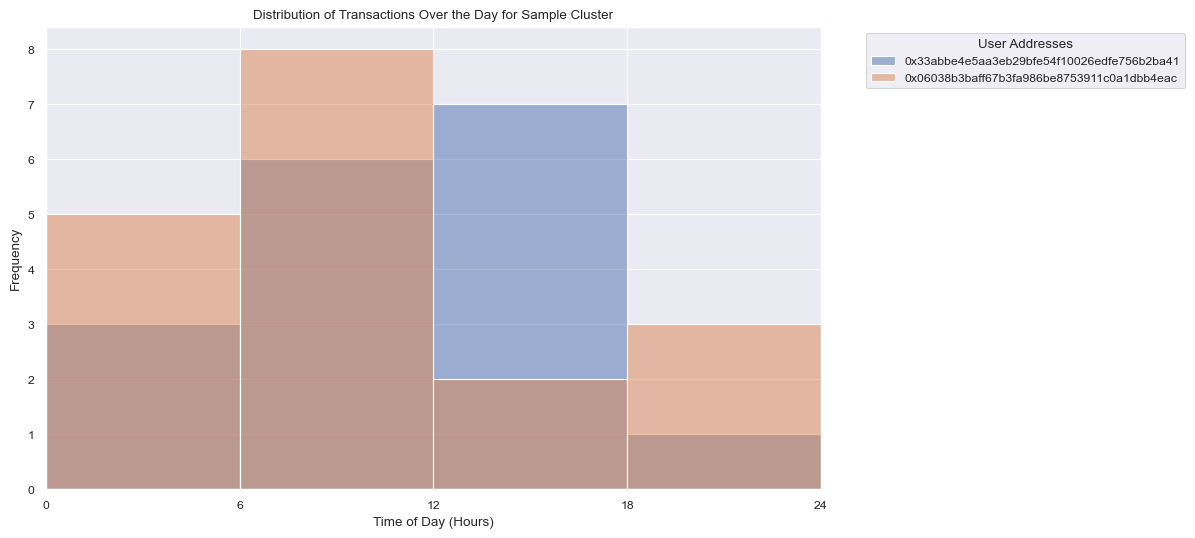

In [70]:
# Create a color palette
colors = plt.cm.viridis(np.linspace(0, 1, len(addresses)))

In [ ]:
## Create network graph
G = nx.from_pandas_edgelist(all_transfers_df, 'from', 'to', create_using=nx.Graph())

# Get the largest connected component (assuming graph is undirected)
largest_cc = max(nx.connected_components(G), key=len)
print(len(largest_cc))

# Create a subgraph of G consisting only of the nodes in the largest connected component
G_cc = G.subgraph(largest_cc)

# Creating a mapping of old node IDs to new node IDs
node_mapping = {node: i for i, node in enumerate(G_cc.nodes)}

# Relabeling the nodes in the graph according to the mapping
G_cc = nx.relabel_nodes(G_cc, node_mapping)

# Initialize Diff2Vec model
model = Diff2Vec(diffusion_number=10, diffusion_cover=40, dimensions=128, window_size=5, learning_rate=0.025) #same as in tutela
model.fit(G_cc)

# Get embeddings
embeddings = model.get_embedding()


## Manual check of Address Pair
#idx1 = node_mapping['0x85e5472752a6f00775faca4d5179bde1081571b0']
#idx2 = node_mapping['0xbf886e3069d0dfd64e384c93da322f775faa8876']
#print(idx1,idx2)

In [ ]:
# Assuming `embeddings` is a 2D numpy array where each row is the embedding of a node
# Normalize embeddings
embeddings = embeddings / np.linalg.norm(embeddings, axis=1, keepdims=True)

# Build the index
index = faiss.IndexFlatL2(embeddings.shape[1])

# Add vectors to the index
index.add(embeddings)

idx = node_map['0x85e5472752a6f00775faca4d5179bde1081571b0']
# Query the index for the nearest neighbors of any embedding
D, I = index.search(embeddings[idx:idx+1], embeddings.shape[0])

# D and I are the distances and indices of the nearest neighbors, respectively
print(D)  # Distance to nearest neighbors
print(I)  # Indices of nearest neighbors